In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mpl_ticker
from pathlib import Path
from mbeml.constants import TargetProperty, unique_cores, roman_numerals
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_names = [
    "training_data",
    "validation_data",
    "composition_test_data",
    "ligand_test_data",
]
data_sets = [pd.read_csv(data_dir / f"{name}.csv") for name in df_names]

In [4]:
dataset_color_dict = {
    "Training set": "C0",
    "Validation set": "C1",
    "Composition test set": "C2",
    "Ligand test set": "C3",
}

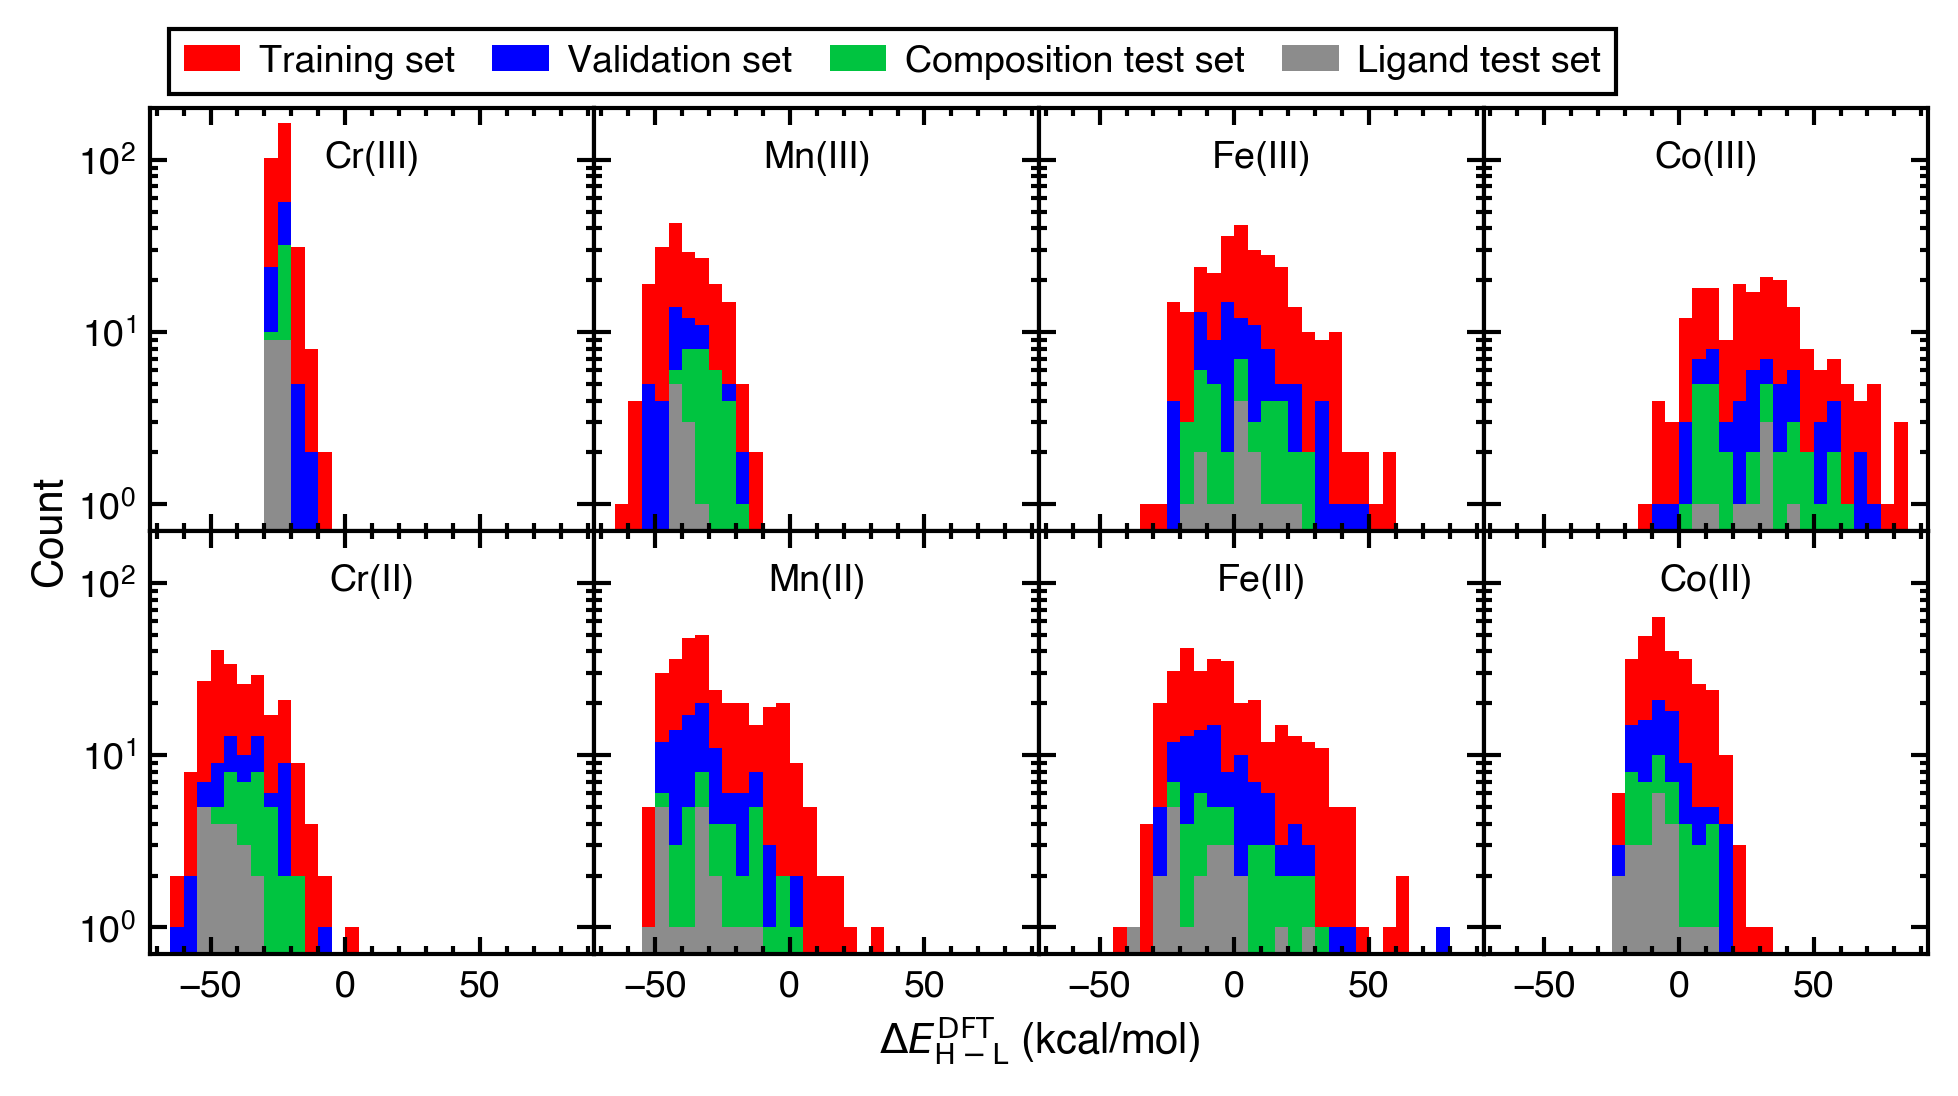

In [5]:
gridspec_kw = {
    "left": 0.08,
    "right": 0.97,
    "top": 0.90,
    "bottom": 0.13,
    "hspace": 0.0,
    "wspace": 0.0,
}
fig, axes = plt.subplots(
    figsize=(6.66, 1.1 * 3.33),
    ncols=4,
    nrows=2,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

bins = np.linspace(-65, 85, 31)

for core, ax in zip(unique_cores, axes.T.flatten()):
    bottoms = np.zeros(len(bins) - 1)
    for i, df in enumerate(data_sets[::-1]):
        cores = df[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
        mask = cores == core
        y = df[mask][TargetProperty.SSE.full_name()]
        counts, _, _ = ax.hist(y, bins=bins, bottom=bottoms, color=f"C{3-i}")
        bottoms += counts
    ax.text(
        10,
        130,
        f"{core[:2].capitalize()}({roman_numerals[core[-1]]})",
        ha="center",
        va="top",
        fontsize=9,
    )
    ax.set_yscale("log")
    ax.set_ylim(0.7, 200)
    ax.set_yticks(
        list(range(2, 10)) + [10 * i for i in range(2, 10)],
        minor=True,
    )
    ax.set_xticks(10 * np.arange(-7, 10), minor=True)

# Labels
fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.09,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "Count",
    rotation=90,
    va="center",
)

# Legend
ax = axes[0, 0]
for label, color in dataset_color_dict.items():
    ax.hist([], label=label, color=color)
ax.legend(loc="upper left", bbox_to_anchor=(0.0, 1.23), ncols=4)
fig.savefig("plots/histogram_sse.pdf")

# Orbitals

In [6]:
from matplotlib.legend_handler import HandlerTuple

alpha_dict = {"LS": 1.0, "HS": 0.6}


def dataset_legend(ax, legend_kwargs=None):
    if legend_kwargs is None:
        legend_kwargs = dict(loc="upper left")

    handles = []
    labels = []
    for metal, color in dataset_color_dict.items():
        handles.append(
            (
                ax.hist([], color=color, alpha=alpha_dict["LS"])[2],
                ax.hist([], color=color, alpha=alpha_dict["HS"])[2],
            )
        )
        labels.append(metal.capitalize())
    for ox, alpha in [("LS", alpha_dict["LS"]), ("HS", alpha_dict["HS"])]:
        handles.append(
            tuple(
                (
                    ax.hist([], color=color, alpha=alpha)[2]
                    for color in dataset_color_dict.values()
                )
            )
        )
        labels.append(ox)

    legend = ax.legend(
        handles,
        labels,
        ncols=6,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=0.0)},
        **legend_kwargs,
    )
    return legend


def orbital_histogram(
    ls_transform,
    hs_transform,
    bins,
    xlabel="Unknown",
    major_ticks=10.0,
    minor_ticks=2.0,
):
    gridspec_kw = {
        "left": 0.08,
        "right": 0.97,
        "top": 0.90,
        "bottom": 0.13,
        "hspace": 0.0,
        "wspace": 0.0,
    }
    fig, axes = plt.subplots(
        figsize=(6.66, 1.1 * 3.33),
        ncols=4,
        nrows=2,
        sharex=True,
        sharey=True,
        gridspec_kw=gridspec_kw,
    )

    for core, ax in zip(unique_cores, axes.T.flatten()):
        bottoms = np.zeros(len(bins) - 1)
        for i, df in enumerate(data_sets[::-1]):
            cores = (
                df[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
            )
            mask = cores == core
            y = ls_transform(
                df[mask][TargetProperty.ORBITALS.full_name()].values
            ).flatten()
            counts, _, _ = ax.hist(
                y, bins=bins, bottom=bottoms, color=f"C{3-i}", alpha=alpha_dict["LS"]
            )
            bottoms += counts
            y = hs_transform(
                df[mask][TargetProperty.ORBITALS.full_name()].values
            ).flatten()
            counts, _, _ = ax.hist(
                y, bins=bins, bottom=bottoms, color=f"C{3-i}", alpha=alpha_dict["HS"]
            )
            bottoms += counts
        ax.text(
            0.92,
            0.9,
            f"{core[:2].capitalize()}({roman_numerals[core[-1]]})",
            ha="right",
            va="top",
            fontsize=9,
            transform=ax.transAxes,
        )
        ax.set_yscale("log")
        ax.set_ylim(0.7, 200)
        ax.set_yticks(
            list(range(2, 10)) + [10 * i for i in range(2, 10)],
            minor=True,
        )
        ax.xaxis.set_major_locator(mpl_ticker.MultipleLocator(major_ticks))
        ax.xaxis.set_minor_locator(mpl_ticker.MultipleLocator(minor_ticks))

    # Labels
    fig.text(
        gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
        gridspec_kw["bottom"] - 0.09,
        xlabel,
        ha="center",
    )
    fig.text(
        0.02,
        gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
        "Count",
        rotation=90,
        va="center",
    )

    dataset_legend(
        axes[0, 0], legend_kwargs=dict(bbox_to_anchor=(-0.03, 1.23), loc="upper left")
    )
    return fig, ax

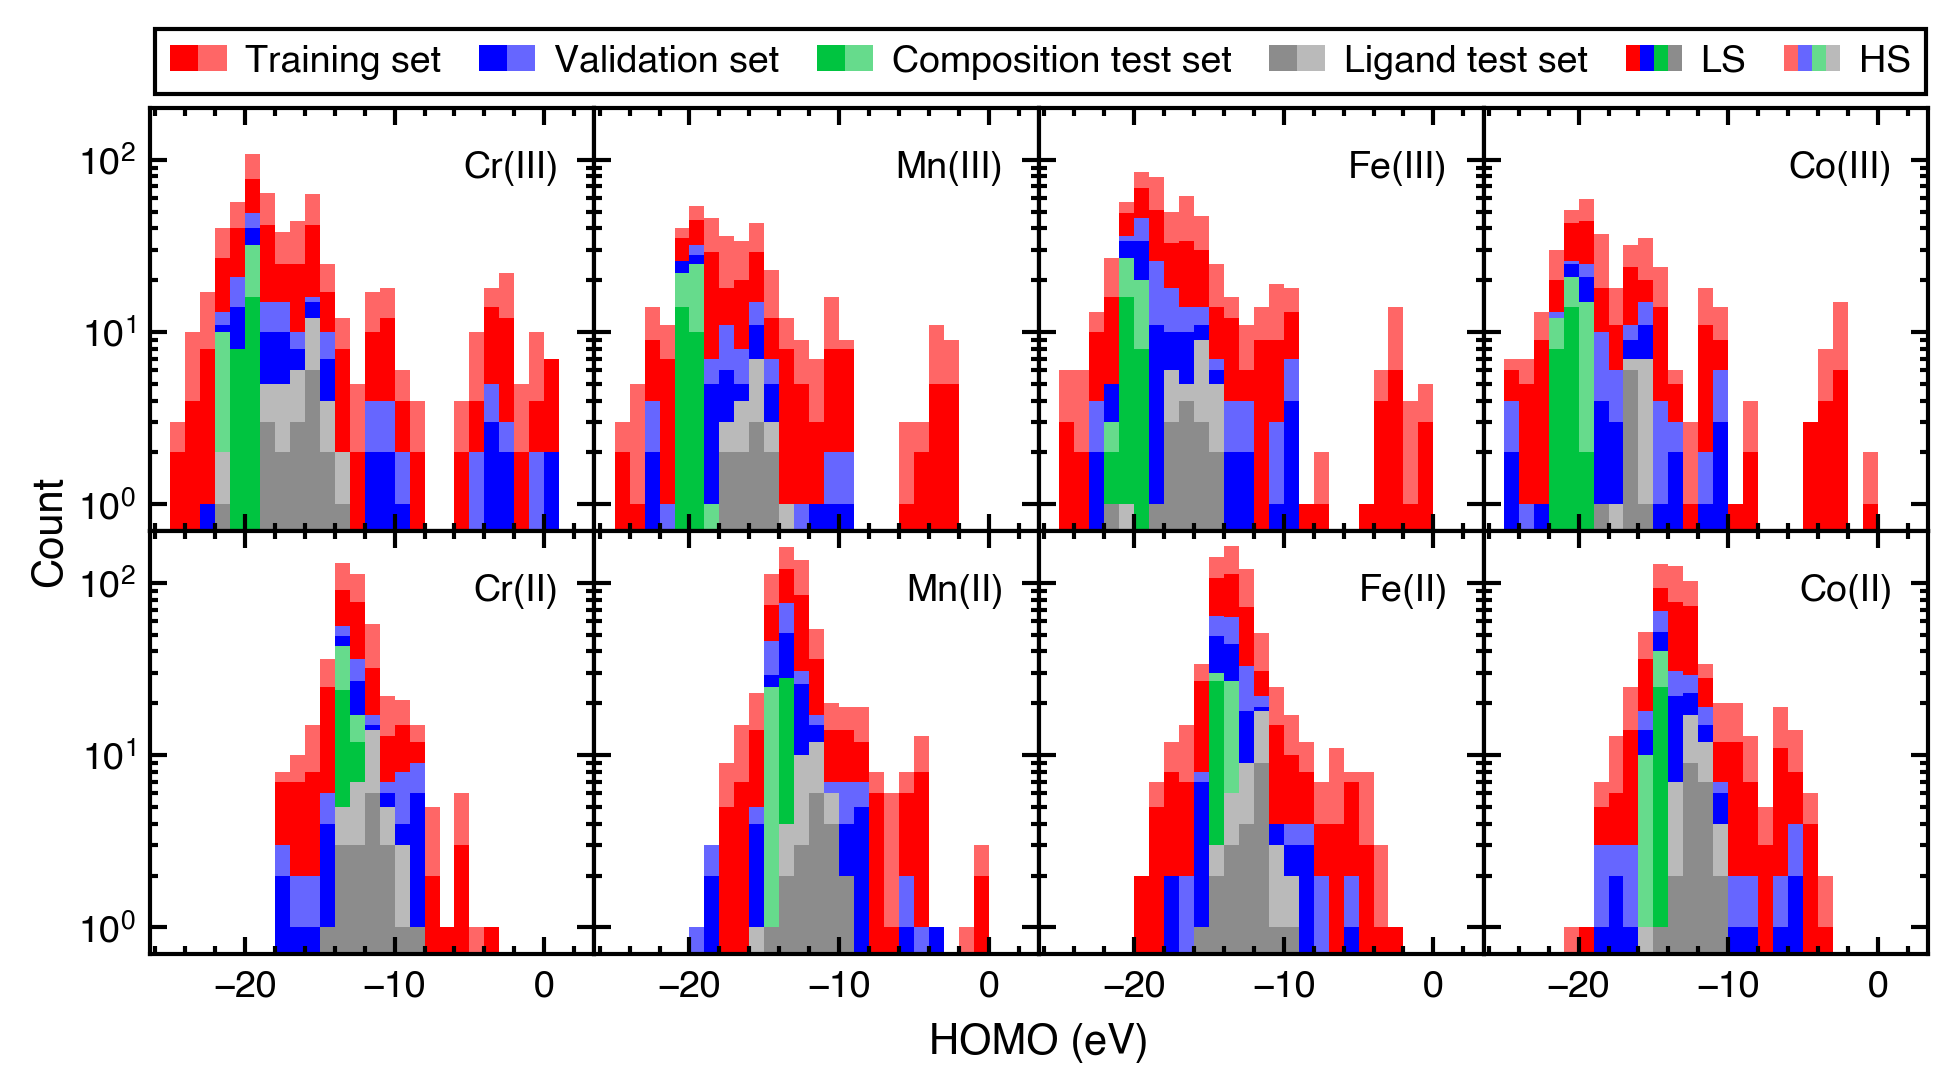

In [7]:
fig, ax = orbital_histogram(
    ls_transform=lambda x: x[:, 0],
    hs_transform=lambda x: x[:, 1],
    bins=np.linspace(-25, 2, 28),
    xlabel="HOMO (eV)",
)
fig.savefig("plots/histogram_homo.pdf")

In [8]:
median_HOMOs = {}
for name, df in zip(df_names, data_sets):
    median_HOMOs[name] = {}
    for core in unique_cores:
        cores = df[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
        mask = cores == core
        HOMOs = df[mask][TargetProperty.ORBITALS.full_name()].values[:, :2].flatten()
        median_HOMOs[name][core] = np.median(HOMOs)
df_median_HOMO = pd.DataFrame.from_dict(median_HOMOs, orient="index")
df_median_HOMO.round(1)

,cr3,cr2,mn3,mn2,fe3,fe2,co3,co2
training_data,-17.6,-12.8,-16.7,-12.9,-17.0,-13.3,-17.6,-13.3
validation_data,-17.9,-12.7,-17.5,-13.4,-18.4,-13.6,-17.9,-13.9
composition_test_data,-19.8,-13.1,-19.8,-14.1,-20.1,-14.1,-20.2,-14.9
ligand_test_data,-16.1,-11.5,-15.9,-11.9,-16.0,-11.9,-16.0,-12.3


In [9]:
pd.concat(
    [
        df_median_HOMO[f"{m}3"] - df_median_HOMO[f"{m}2"]
        for m in ["cr", "mn", "fe", "co"]
    ],
    axis=1,
).mean(axis=1)

training_data           -4.156199
validation_data         -4.534097
composition_test_data   -5.951470
ligand_test_data        -4.100756
dtype: float64

In [10]:
cols = {}
for core in unique_cores:
    col = {}
    for i, (df, df_name) in enumerate(zip(data_sets, df_names)):
        cores = df[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
        mask = cores == core
        y = df[mask][TargetProperty.ORBITALS.full_name()].values[:, :2].flatten()
        col[df_name] = y.std()
    cols[core] = col
pd.DataFrame.from_dict(cols).round(2)

,cr3,cr2,mn3,mn2,fe3,fe2,co3,co2
training_data,6.24,2.24,5.20,2.87,5.32,2.81,5.76,3.01
validation_data,6.23,2.39,3.17,2.40,3.20,2.03,3.82,2.64
composition_test_data,0.54,0.24,0.44,0.45,0.44,0.39,0.73,0.32
ligand_test_data,1.73,1.25,1.00,1.15,1.64,1.18,0.81,1.03


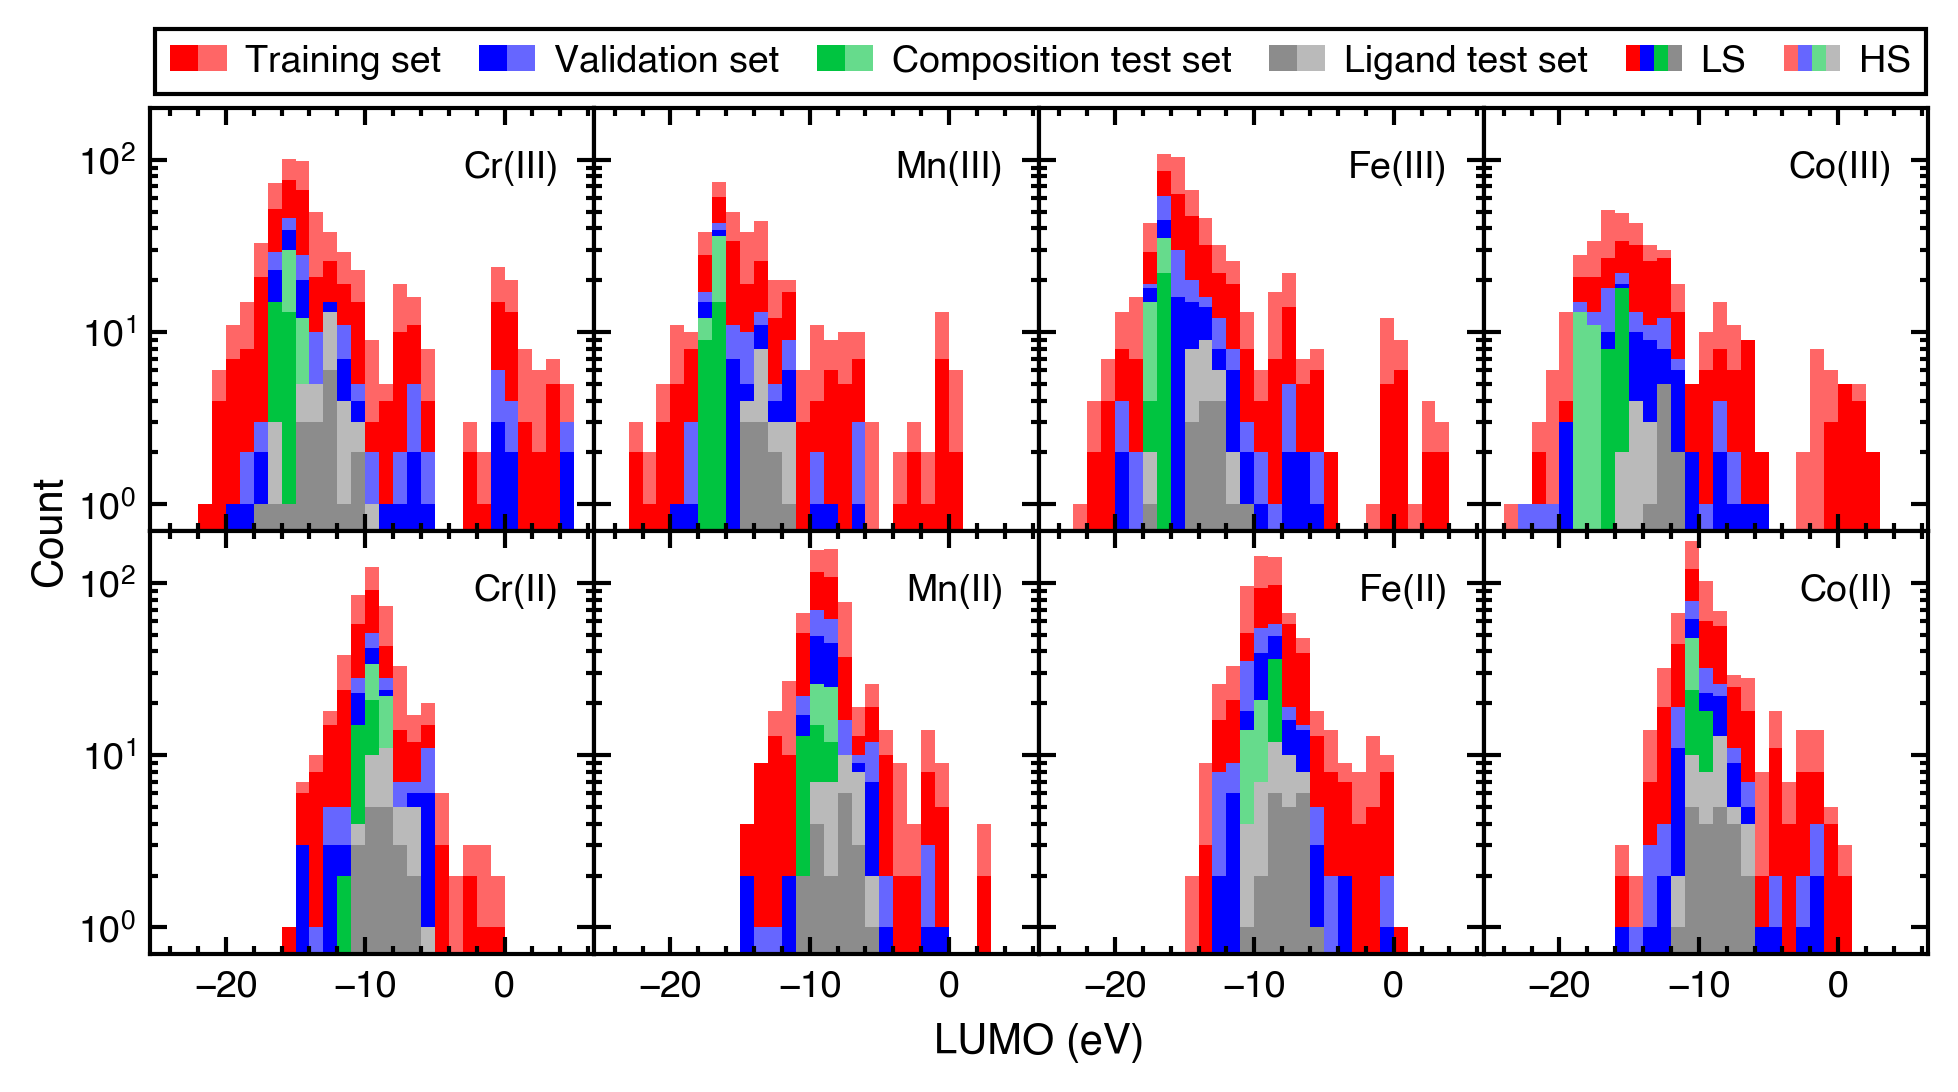

In [11]:
fig, ax = orbital_histogram(
    ls_transform=lambda x: x[:, 2],
    hs_transform=lambda x: x[:, 3],
    bins=np.linspace(-24, 5, 30),
    xlabel="LUMO (eV)",
)
fig.savefig("plots/histogram_lumo.pdf")

In [12]:
cols = {}
for core in unique_cores:
    col = {}
    for i, (df, df_name) in enumerate(zip(data_sets, df_names)):
        cores = df[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
        mask = cores == core
        y = df[mask][TargetProperty.ORBITALS.full_name()].values[:, 2:].flatten()
        col[df_name] = y.std()
    cols[core] = col
pd.DataFrame.from_dict(cols).round(2)

,cr3,cr2,mn3,mn2,fe3,fe2,co3,co2
training_data,6.07,2.35,5.24,2.84,5.21,2.77,5.56,3.04
validation_data,6.26,2.36,3.12,2.16,3.04,2.12,3.65,2.65
composition_test_data,0.46,0.71,0.40,0.61,0.38,0.66,1.15,0.35
ligand_test_data,1.80,1.37,1.00,1.27,1.59,1.33,1.33,1.29


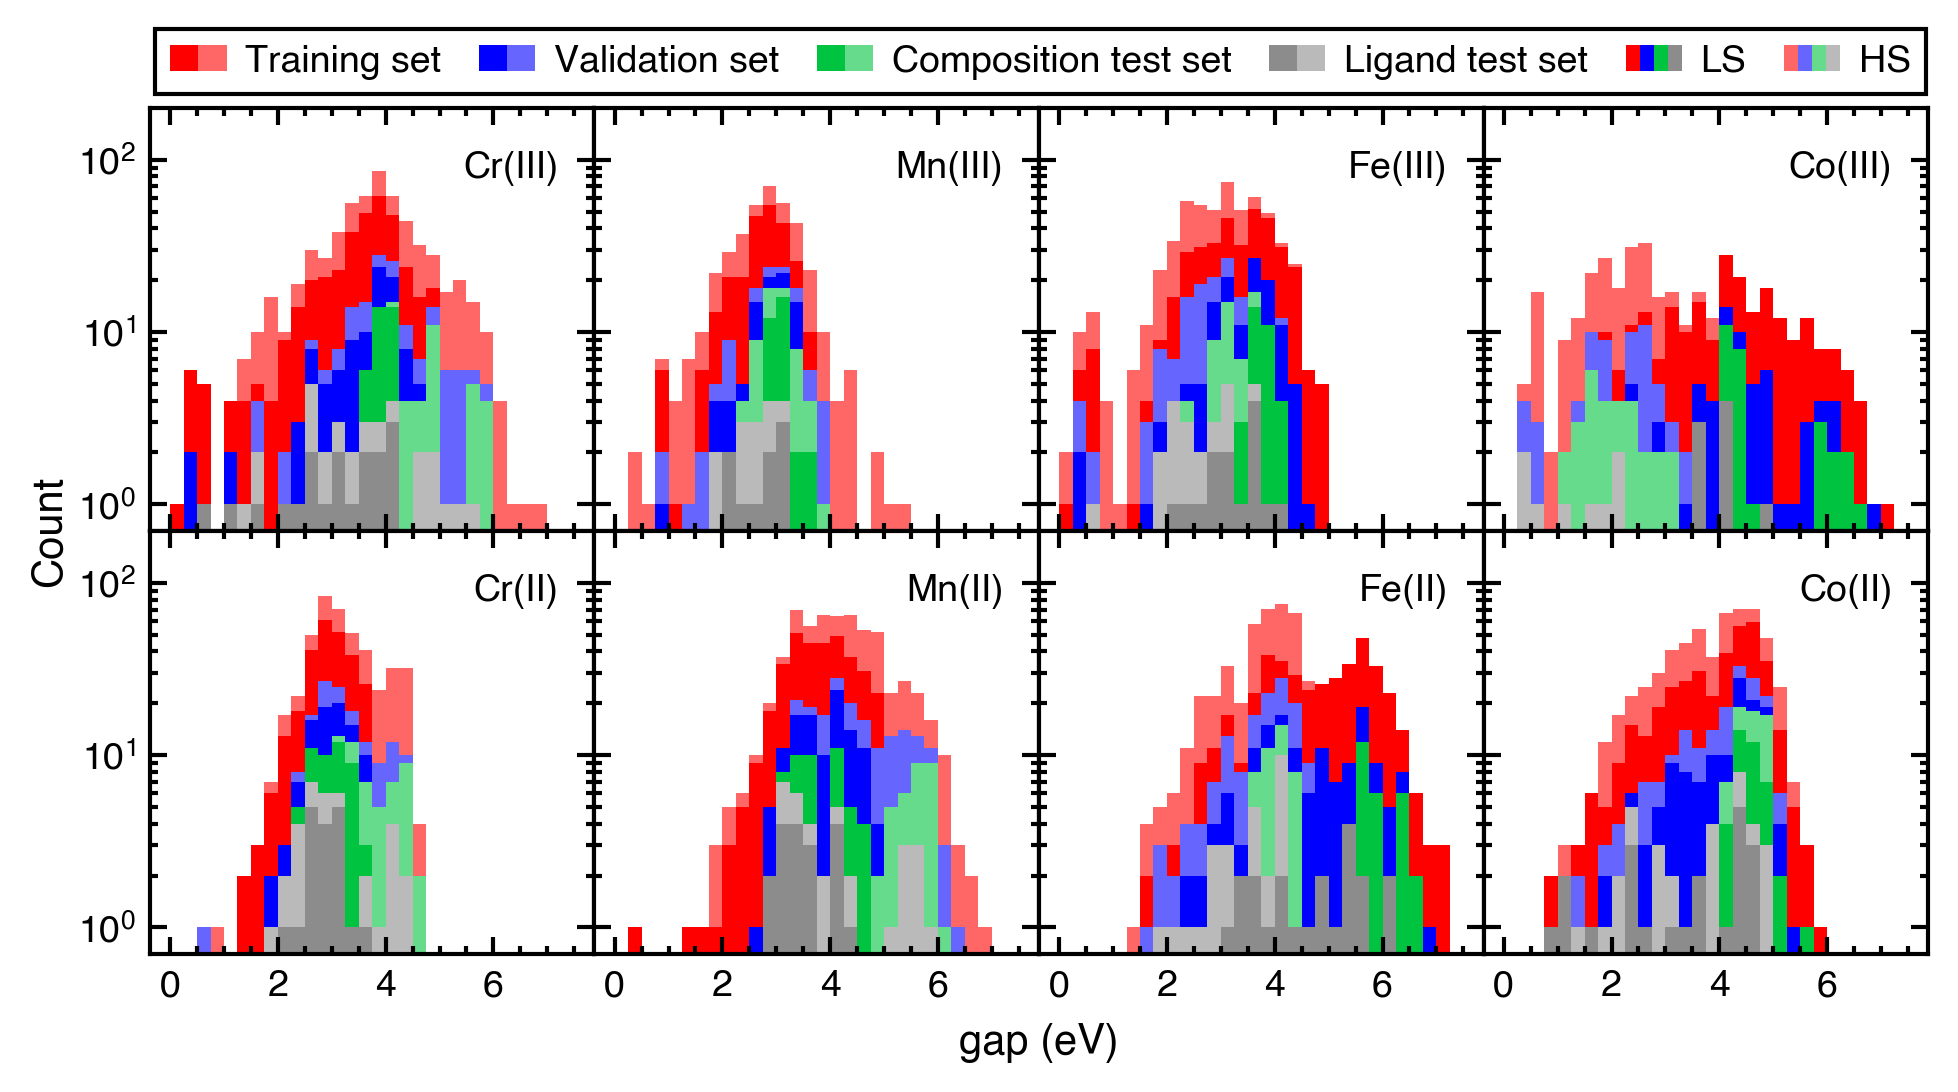

In [13]:
fig, ax = orbital_histogram(
    ls_transform=lambda x: x[:, 2] - x[:, 0],
    hs_transform=lambda x: x[:, 3] - x[:, 1],
    bins=np.linspace(0.0, 7.5, 31),
    xlabel="gap (eV)",
    major_ticks=2.0,
    minor_ticks=0.5,
)
fig.savefig("plots/histogram_gap.pdf")

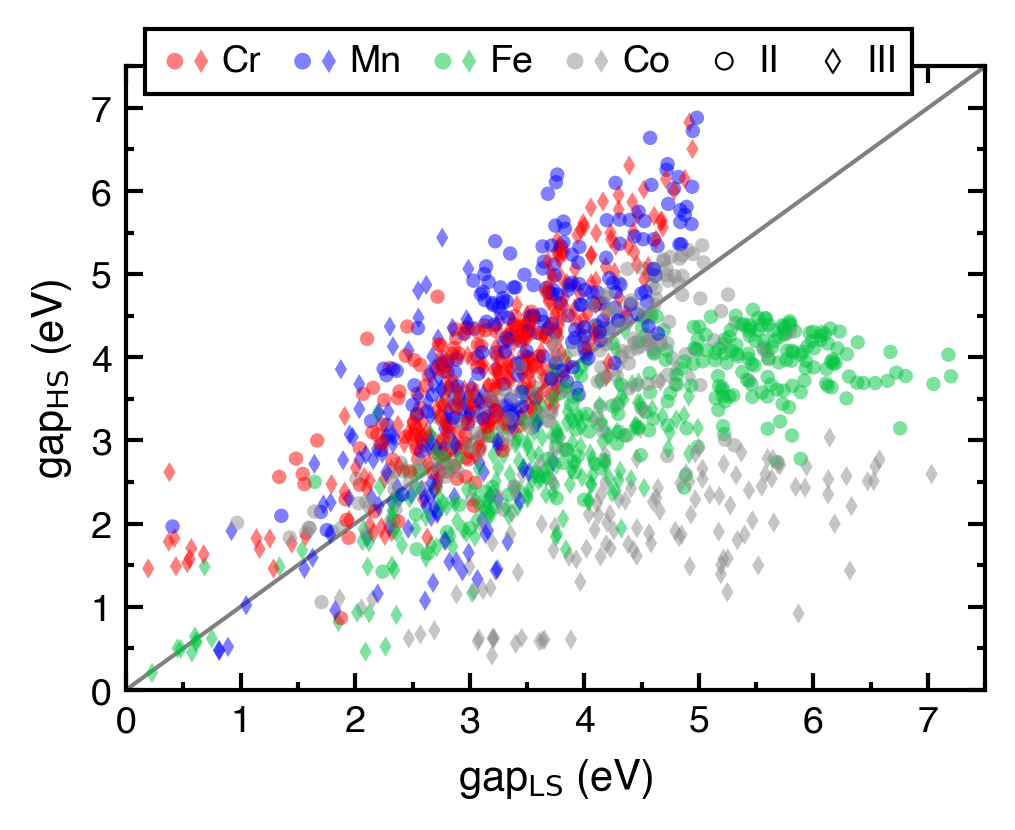

In [78]:
df_train = data_sets[0]

cores = df_train[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
colors = [color_dict[core[:2]] for core in cores]
markers = [marker_dict[core[-1]] for core in cores]

gap_ls = (
    df_train[TargetProperty.ORBITALS.full_name()].values[:, 2].flatten()
    - df_train[TargetProperty.ORBITALS.full_name()].values[:, 0].flatten()
)
gap_hs = (
    df_train[TargetProperty.ORBITALS.full_name()].values[:, 3].flatten()
    - df_train[TargetProperty.ORBITALS.full_name()].values[:, 1].flatten()
)

gridspec_kw = {
    "left": 0.11,
    "right": 0.97,
    "top": 0.93,
    "bottom": 0.15,
}
fig, ax = plt.subplots(figsize=(3.33, 0.8 * 3.33), gridspec_kw=gridspec_kw)
scatter_random_z(
    ax,
    gap_ls,
    gap_hs,
    colors=colors,
    markers=markers,
    s=12,
    alpha=0.5,
    edgecolors="none",
)

upper_lim = 7.5
ax.plot([0, upper_lim], [0, upper_lim], color="0.5", zorder=0)
ax.set_xlim([0, upper_lim])
ax.set_ylim([0, upper_lim])
ax.set_xlabel("gap$_\mathrm{LS}$ (eV)")
ax.set_ylabel("gap$_\mathrm{HS}$ (eV)")
ax.xaxis.set_major_locator(mpl_ticker.MultipleLocator(1.0))
ax.yaxis.set_major_locator(mpl_ticker.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(mpl_ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(mpl_ticker.MultipleLocator(0.5))
core_legend(
    ax,
    legend_kwargs=dict(
        bbox_to_anchor=(0.0, 1.09),
        loc="upper left",
        markerscale=0.9,
        handletextpad=0.15,
        columnspacing=0.7,
    ),
)
fig.savefig("plots/parity_plot_gap_ls_hs.pdf")

In [70]:
from mbeml.metrics import r2_score

correlations = {}

metrics = [
    ("corr_coef", lambda x, y: np.corrcoef(x, y)[0, 1]),
    ("r2", r2_score),
]

for core in unique_cores:
    mask = cores == core
    row = {}
    for name, metric in metrics:
        row[name] = metric(gap_ls[mask], gap_hs[mask])
    correlations[core] = row
row = {}
for name, metric in metrics:
    row[name] = metric(gap_ls, gap_hs)
correlations["all"] = row
pd.DataFrame.from_dict(correlations).round(2)

,cr3,cr2,mn3,mn2,fe3,fe2,co3,co2,all
corr_coef,0.89,0.56,0.34,0.74,0.78,0.69,0.50,0.83,0.41
r2,0.23,-1.87,-1.86,-0.99,-0.09,-1.53,-5.16,0.65,-0.21
